# Pré-processamento

In [41]:
import pickle
import swifter
import numpy as np
import pandas as pd

from pathlib import Path

## importando dados

Arquivo: `../data/german.data`

In [42]:
datapath = Path('../data')  # defining absolute path to database (it's meant to work across different OS)

In [43]:
data = pd.read_table(f'{datapath}/german.data', sep=' ', header=None)

# opcional: import diretamente do repositório UCL
#data = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', 
#                     sep=' ', header=None)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### conferindo dimensões do dataset

In [44]:
assert data.shape[0] == 1000, 'o dataset não contém o número correto de registros. Esperado: 1000 linhas'
assert data.shape[1] == 21, 'o dataset não contém o número correto de colunas. Esperado: 20 features + resposta'

## nomeando colunas

In [45]:
col_names = [
    'status_check_acc',
    'duration',
    'cred_history',
    'purpose',
    'cred_amount',
    'savings',
    'employment_since',
    'installment',
    'status_sex',
    'other_deb',
    'resid_since',
    'property',
    'age',
    'other_installment',
    'housing',
    'n_creds',
    'job',
    'n_liable_people',
    'tel',
    'foreign',
    'cred_score'   # Y variable (1 = Good, 2 = Bad)
]

In [46]:
data.columns = col_names

## conferindo dtypes

In [47]:
data.dtypes

status_check_acc     object
duration              int64
cred_history         object
purpose              object
cred_amount           int64
savings              object
employment_since     object
installment           int64
status_sex           object
other_deb            object
resid_since           int64
property             object
age                   int64
other_installment    object
housing              object
n_creds               int64
job                  object
n_liable_people       int64
tel                  object
foreign              object
cred_score            int64
dtype: object

As colunas numéricas foram corretamente identificadas como `int`. No entanto, as colunas de tipo `object` precisam ser convertidas para `category` a fim de otimizar seu tempo de processamento (formato mais otimizado pelo pandas para variáveis categóricas).

**obs:** também vamos converter o formato da coluna cred_score por se tratar de uma categoria.

In [48]:
for col in data.columns:
    if data[col].dtype == 'object' or col == 'cred_score':
        data[col] = data[col].astype('category')
        
data.dtypes

status_check_acc     category
duration                int64
cred_history         category
purpose              category
cred_amount             int64
savings              category
employment_since     category
installment             int64
status_sex           category
other_deb            category
resid_since             int64
property             category
age                     int64
other_installment    category
housing              category
n_creds                 int64
job                  category
n_liable_people         int64
tel                  category
foreign              category
cred_score           category
dtype: object

## conferindo *missing values*

In [49]:
missing_vals = data.isna().sum().reset_index().rename(columns={'index':'feature', 0:'n_missing'})

for idx, row in missing_vals.iterrows():
    if row['n_missing'] > 0:
        print(f'Warning: há {row.n_missing} valores faltantes na coluna {row.feature}.')

**OBS:** Não foram identificados valores faltantes. Caso houvesse *missing data*, poderíamos adotar uma estratégia de imputação usando, por exemplo, algoritmos KNN ou Naive Bayes para variáveis categóricas. Variáveis numéricas, se possível, poderiam ter seus valores recuperados pela média ou mediana, por exemplo.

## Feature Engineering

Vamos começar transformando a variável resposta em binária para facilitar seu uso e interpretação nos modelos de classificação. Relembrando, a variável resposta `cred_score` está definida como:

```bash
    1 = bom,
    2 = ruim
```

Sua versão binária será uma variável indicadora, assumindo o valor 1 se um dado indivíduo apresenta score de crédito ruim, e 0 caso contrário. Dessa forma, 

```bash
    0 = bom,
    1 = ruim
```

In [50]:
data['cred_score'] = data['cred_score'].astype(int) - 1
data['cred_score'] = data['cred_score'].astype('category')

Em seguida, vamos tratar as demais variáveis categóricas que estão codificadas. 

<br>

### status_check_acc

representa o status de uma conta corrente existente

In [51]:
status_acc_codes = {
    'A11' : '0 DM',
    'A12' : '<200 DM',
    'A13' : '>=200 DM',
    'A14' : 'None'
}

In [52]:
# decodificando coluna, acelerando com swifter
data['status_check_acc'] = data['status_check_acc'].swifter.apply(lambda x: status_acc_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

**OBS:** a biblioteca `swifter` paraleliza aplicações do apply, o que pode ser muito útil para acelerar o uso do apply em grandes datasets.

<br>

### cred_history

histórico de crédito

In [53]:
cred_hist_codes = {
    'A30' : 'not taken/paid duly',
    'A31' : 'all paid (this bank)',
    'A32' : 'all paid',
    'A33' : 'delayed',
    'A34' : 'critical'
}

In [54]:
data['cred_history'] = data['cred_history'].swifter.apply(lambda x: cred_hist_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

### Purpose

Motivo da solicitação de crédito

In [55]:
purpose_codes = {
    'A40' : 'car (new)',  # new
    'A41' : 'car (used)', # used
    'A42' : 'furniture/equipment',
    'A43' : 'radio/television',
    'A44' : 'domestic appliances',
    'A45' : 'repairs',
    'A46' : 'education',
    'A47' : 'vacation',
    'A48' : 'retraining',
    'A49' : 'business',
    'A410' : 'others'
}

<AxesSubplot:>

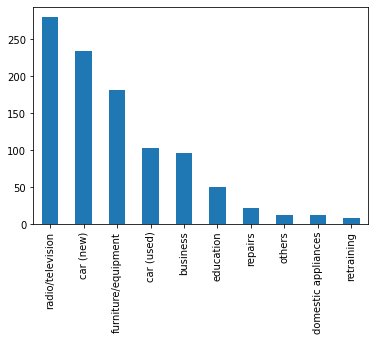

In [56]:
data['purpose'].apply(lambda x:purpose_codes[x]).value_counts().plot(kind='bar')

<font color='red'>**OBS:**</font> Por fins de simplificação, vou agregar as categorias "car (new)" e "car (used)". Dessa forma, podemos simplificar como um único propósito de comprar um carro.

In [57]:
purpose_codes = {
    'A40' : 'car',  # new
    'A41' : 'car', # used
    'A42' : 'furniture/equipment',
    'A43' : 'radio/television',
    'A44' : 'domestic appliances',
    'A45' : 'repairs',
    'A46' : 'education',
    'A47' : 'vacation',
    'A48' : 'retraining',
    'A49' : 'business',
    'A410' : 'others'
}

In [58]:
data['purpose'] = data['purpose'].swifter.apply(lambda x: purpose_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

### savings

Quantia presente em conta poupança / títulos públicos

In [59]:
savings_codes = {
    'A61' :  '<100 DM',
    'A62' :  '<500 DM',
    'A63' :  '<1000 DM',
    'A64' :  '>= 1000 DM',
    'A65' :  'None'
}

In [60]:
data['savings'] = data['savings'].swifter.apply(lambda x: savings_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

### employment_since

Tempo de permanência no emprego atual

In [61]:
employment_codes = {
    'A71' : 'unemployed',
    'A72' : '< 1 year',   
    'A73' : '< 4 years',   
    'A74' : '< 7 years',  
    'A75' : '>= 7 years'  
}

In [62]:
data['employment_since'] = data['employment_since'].swifter.apply(lambda x: employment_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

### status_sex

Vamos dividir essa coluna em duas: `social_status` e `gender`.

In [63]:
gender_codes = {
    'A91' : 'M', 
    'A92' : 'F', 
    'A93' : 'M',  
    'A94' : 'M',   
    'A95' : 'F',
}

social_status_codes = {
    'A91' : 'divorced/separated',
    'A92' : 'divorced/separated',  # obs: como essa classe é dominada pela anterior, vou mapear igualmente 
    'A93' : 'single',
    'A94' : 'married/widowed',
    'A95' : 'single',
}

In [64]:
data['gender'] = data['status_sex'].swifter.apply(lambda x: gender_codes[x])
data['social_status'] = data['status_sex'].swifter.apply(lambda x: social_status_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

In [65]:
# para evitar duplicidade, vamos remover a soluna status_sex
data = data.drop('status_sex', axis=1)

### other_deb

Essa variável informa se o cliente é garantidor / fiador de outra pessoa

In [66]:
other_deb_codes = {
    'A101' : 'None',
    'A102' : 'co-applicant',
    'A103' : 'guarantor'
}

In [67]:
data['other_deb'] = data['other_deb'].swifter.apply(lambda x:other_deb_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

### Property

Bem dado como garantia!?

In [68]:
property_codes = {
    'A121' : 'real estate',
    'A122' : 'savings/life insurance',
    'A123' : 'car',
    'A124' : 'unknown/none'
}

In [69]:
data['property'] = data['property'].swifter.apply(lambda x: property_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

### other_installment

outros planos de parcelamento!?

In [70]:
other_installment_codes = {
    'A141' : 'bank',
    'A142' : 'stores',
    'A143' : 'none'
}

In [71]:
data['other_installment'] = data['other_installment'].swifter.apply(lambda x:other_installment_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

### housing

Tipo de residência

In [72]:
housing_codes = {
    'A151' : 'rent',
    'A152' : 'own',
    'A153' : 'free'
}

In [73]:
data['housing'] = data['housing'].swifter.apply(lambda x: housing_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

### jobs

In [74]:
jobs_codes = {
    'A171' : 'unemployed/unskilled',  
    'A172' : 'unskilled (resident)',
    'A173' : 'skilled',
    'A174' : 'executive/highly skilled'
}

In [75]:
data['job'] = data['job'].swifter.apply(lambda x:jobs_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

### Tel

registered telephone number?

In [76]:
tel_codes = {
    'A191' : 0,  # no
    'A192' : 1   # yes
}

In [77]:
data['tel'] = data['tel'].swifter.apply(lambda x:tel_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

### Foreign

the client is a foreign worker?

In [78]:
foreign_codes = {
    'A201' : 1,  # yes
    'A202' : 0   # no
}

In [79]:
data['foreign'] = data['foreign'].swifter.apply(lambda x: foreign_codes[x])

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

## exportando a base de dados

Por fins de organização, vou exportar a base de dados em um pickle para uso em outros notebooks.

In [80]:
with open(f'{datapath}/data.pickle', 'wb') as file:
    pickle.dump(data, file)

**Fim!**

<font color='red'>Confira os demais notebooks para visualizar análises descritivas/preditivas.</font>